In [4]:
%pylab inline
import os
import gc
import scipy
import catutil
import numpy as np
import imgSimutil as imgUtil
import astropy.io.fits as pyfits
from astropy.table import Table,vstack,hstack
import numpy.lib.recfunctions as rfn

Populating the interactive namespace from numpy and matplotlib


In [2]:
cd wrkDir/FPFS2/sim2/

/lustre/work/xiangchong.li/work/FPFS2/sim2


In [52]:
names=['ext_shapeHSM_HsmShapeRegauss_e1','ext_shapeHSM_HsmShapeRegauss_e2','base_SdssShape_x','base_SdssShape_y',\
       'modelfit_CModel_instFlux','modelfit_CModel_instFluxErr','ext_shapeHSM_HsmShapeRegauss_resolution']
pltDir='../../galSim-HSC/s19/s19-1/anaCat_newS19Mask_fdeltacut/plot/optimize_weight/'

pix_scale=  0.168/3600.
cosmo252=   imgUtil.cosmoHSTGal('252')
cosmo252E=   imgUtil.cosmoHSTGal('252E')
#for index in range(133):
index   =   4
pixId   =   imgUtil.cosmoHSThpix[index]
dd      =   cosmo252.hpInfo[cosmo252.hpInfo['pix']==pixId]
nx      =   int(dd['dra']/pix_scale)
ny      =   int(dd['ddec']/pix_scale)

if False:
    if False:
        hstcat  =   cosmo252.readHpixSample(pixId)
    else:
        cat_tmp1=   cosmo252.readHpixSample(pixId)[['xI','yI','zphot','mag_auto','index']]
        cat_tmp2=   cosmo252E.readHpixSample(pixId)[['xI','yI','zphot','mag_auto','index']]
        hstcat  =   rfn.stack_arrays([cat_tmp1,cat_tmp2],usemask=False,autoconvert=True)
else:
    hstcat=pyfits.getdata('hstcat.fits')
msk     =   (hstcat['xI']>32)&(hstcat['yI']>32)&(hstcat['xI']<nx-32)&(hstcat['yI']<ny-32)
hstcat  =   hstcat[msk]
xyRef   =   np.vstack([hstcat['xI'],hstcat['yI']]).T
tree    =   scipy.spatial.cKDTree(xyRef)
del msk,xyRef
gc.collect()

16957

In [55]:
ii=0
inoi=0
data=Table.read('outCosmoR-var36em4/src-psf60-%d/src%04d-g1-0000.fits' %(pixId,inoi))
data['a_i']=0.
wlmsk=catutil.get_wl_flags(data)
data=data[names][wlmsk]
xyDat=np.vstack([data['base_SdssShape_x'],data['base_SdssShape_y']]).T
dis,inds=tree.query(xyDat,k=1)

In [56]:
matcat=hstcat[inds]
mask=(dis<=(0.8/0.168))
data=data[mask]
matcat=matcat[mask]
sigmae  =   catutil.get_sigma_e_model(data,pltDir)
data['i_hsmshaperegauss_derived_sigma_e']=   sigmae
erms    =   catutil.get_erms_model(data,pltDir)
data['i_hsmshaperegauss_derived_rms_e']  =   erms
data['i_hsmshaperegauss_derived_weight'] =   1./(sigmae**2 + erms**2)
data['mag_auto']=matcat['mag_auto']
data['zphot']=matcat['zphot']
data['cosmo_index']=matcat['index']

In [57]:
data['dnnz_photoz_best']=data['zphot']
pltDir='../../galSim-HSC/s19/s19-1/anaCat_newS19Mask_fdeltacut/plot/reGausCalib/'
model_m =   catutil.get_m_model(data,weight_bias=True,photo_z_dep=True,pltDir=pltDir)

In [58]:
catutil.get_sel_bias(data['i_hsmshaperegauss_derived_weight'],catutil.get_imag_A10(data),catutil.get_res(data))

(0.04011560896508248,
 0.013301491393685244,
 0.0027447521923477484,
 0.001900213056240749)

In [59]:
1./(1+np.sum(model_m*data['i_hsmshaperegauss_derived_weight'])/np.sum(data['i_hsmshaperegauss_derived_weight']))/(1+0.0465)

1.0631626370334146

(array([ 38.,  38.,  38.,  44.,  49.,  55.,  63.,  61.,  78.,  86.,  90.,
         96., 113., 115., 114., 116., 165., 194., 221., 258., 245., 291.,
        310., 363., 411., 423., 507., 548., 560., 604., 653., 701., 713.,
        709., 676., 683., 567., 440., 320., 225.]),
 array([21.  , 21.15, 21.3 , 21.45, 21.6 , 21.75, 21.9 , 22.05, 22.2 ,
        22.35, 22.5 , 22.65, 22.8 , 22.95, 23.1 , 23.25, 23.4 , 23.55,
        23.7 , 23.85, 24.  , 24.15, 24.3 , 24.45, 24.6 , 24.75, 24.9 ,
        25.05, 25.2 , 25.35, 25.5 , 25.65, 25.8 , 25.95, 26.1 , 26.25,
        26.4 , 26.55, 26.7 , 26.85, 27.  ]),
 <a list of 40 Patch objects>)

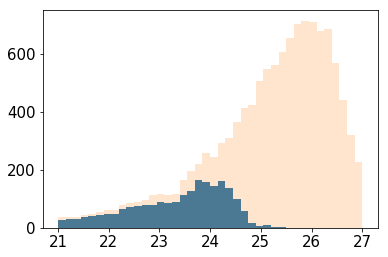

In [70]:
plt.hist(matcat['mag_auto'],bins=40,range=(21,27))
plt.hist(hstcat['mag_auto'],bins=40,range=(21,27),alpha=0.2)

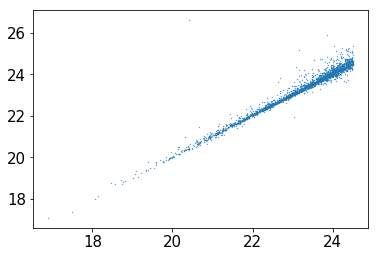

In [60]:
plt.scatter(catutil.get_imag(data),matcat['mag_auto'],s=0.1)

The measured magnitude is brighter than that of the input by: 0.09282764081185117


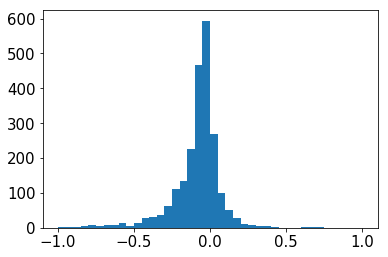

In [63]:
_=plt.hist(catutil.get_imag(data)-matcat['mag_auto'],bins=40,range=(-1,1))
print('The measured magnitude is brighter than that of the input by:',\
      np.nanmean(matcat['mag_auto']-catutil.get_imag(data)))

## Match distance test

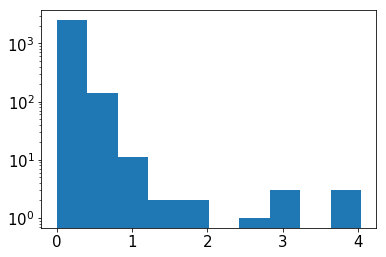

In [36]:
plt.hist(dis[mask])
plt.yscale('log')

In [27]:
datSelX=data[]['base_SdssShape_x']
datSelY=data[out[1]]['base_SdssShape_y']

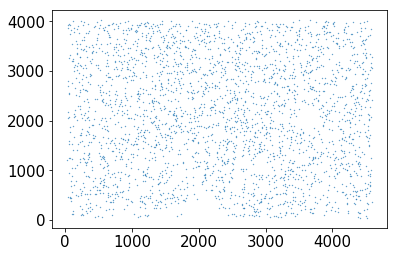

In [40]:
plt.scatter(data['base_SdssShape_x'],data['base_SdssShape_y'],s=0.1)

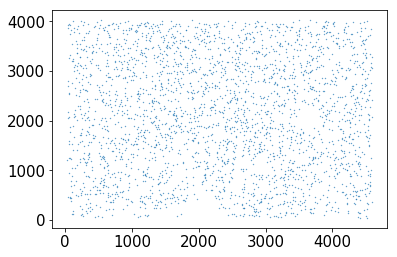

In [38]:
plt.scatter(matcat['xI'],matcat['yI'],s=0.1)